https://gist.github.com/bsweger/e5817488d161f37dcbd2

http://stackoverflow.com/questions/20250689/plotting-a-large-number-of-points-using-matplotlib-and-running-out-of-memory

http://stackoverflow.com/questions/19092812/measure-max-memory-usage-with-ipython-like-timeit-but-memit

http://nbviewer.jupyter.org/gist/jiffyclub/3062428

http://nvie.com/posts/iterators-vs-generators/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib notebook
%matplotlib inline 
plt.style.use('seaborn-bright')

import pickle
from IPython.display import display

%load_ext memory_profiler
%load_ext line_profiler

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 50)

pd.set_option('display.max_columns', 0)

%load_ext autoreload
%autoreload

height has been deprecated.



In [ ]:
# ipython debugger
# %pdb on
# %pdb off

# inline breakpoint
from pdb import set_trace as bp; bp()

In [85]:
# adding labels to groups
df = pd.DataFrame({'val': [10,40,30,10,11,13]}, index=pd.date_range('2016-01-01 00:00:00', periods=6, freq='12H' ) )

df['label'] = df.groupby(pd.TimeGrouper('D')).grouper.group_info[0] + 1

df

,val,label
2016-01-01 00:00:00,10,1
2016-01-01 12:00:00,40,1
2016-01-02 00:00:00,30,2
2016-01-02 12:00:00,10,2
2016-01-03 00:00:00,11,3
2016-01-03 12:00:00,13,3


In [79]:
# getting generator object from groupby
df = pd.DataFrame({'val': [10,40,30,10,11,12,10,11,12,19]}, index=pd.date_range('2016-01-01 19:00:00', periods=10, freq='H' ) )
display(df)

def myf(df, generator):
    for value in generator():
        display(value)

myf(df, df.groupby(pd.TimeGrouper('2h')).__iter__ )

,val
2016-01-01 19:00:00,10
2016-01-01 20:00:00,40
2016-01-01 21:00:00,30
2016-01-01 22:00:00,10
2016-01-01 23:00:00,11
2016-01-02 00:00:00,12
2016-01-02 01:00:00,10
2016-01-02 02:00:00,11
2016-01-02 03:00:00,12
2016-01-02 04:00:00,19


(Timestamp('2016-01-01 18:00:00', offset='2H'),                      val
 2016-01-01 19:00:00   10)

(Timestamp('2016-01-01 20:00:00', offset='2H'),                      val
 2016-01-01 20:00:00   40
 2016-01-01 21:00:00   30)

(Timestamp('2016-01-01 22:00:00', offset='2H'),                      val
 2016-01-01 22:00:00   10
 2016-01-01 23:00:00   11)

(Timestamp('2016-01-02 00:00:00', offset='2H'),                      val
 2016-01-02 00:00:00   12
 2016-01-02 01:00:00   10)

(Timestamp('2016-01-02 02:00:00', offset='2H'),                      val
 2016-01-02 02:00:00   11
 2016-01-02 03:00:00   12)

(Timestamp('2016-01-02 04:00:00', offset='2H'),                      val
 2016-01-02 04:00:00   19)

In [55]:
# flattening history for autoregression
df = pd.DataFrame({'val': [10,40,30,10,11,12]})
display(df)
for i in range(1,4):
    df['val_t-' + str(i)] = df['val'].shift(i)
    
display(df)

,val
0,10
1,40
2,30
3,10
4,11
5,12


,val,val_t-1,val_t-2,val_t-3
0,10,NaN,NaN,NaN
1,40,10.0,NaN,NaN
2,30,40.0,10.0,NaN
3,10,30.0,40.0,10.0
4,11,10.0,30.0,40.0
5,12,11.0,10.0,30.0


In [52]:
# searching row numbers of a index. NOTE: doesnt apply to unsorted column values
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,20,12], 'type':[0,0,0,2,0,2,2]})
df.index = df.k
df = df.drop('k',1)

display(df)

print df.index.searchsorted(1, side='left')
print df.index.searchsorted(3, side='right')

# df.v.searchsorted(20, side='right') # don't do this, gives false answers

,type,v
k,,
1,0,10
1,0,20
2,0,40
2,2,30
3,0,10
3,2,20
3,2,12


0
7


In [49]:
# NaN values in certain column
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [np.nan,20,40,30,10,11,np.nan], 'type':[0,0,0,2,0,2,2]})
display(df)
ind = ~pd.isnull(df['v'])
df[ind]

,k,type,v
0,1,0,NaN
1,1,0,20.0
2,2,0,40.0
3,2,2,30.0
4,3,0,10.0
5,3,2,11.0
6,3,2,NaN


,k,type,v
1,1,0,20.0
2,2,0,40.0
3,2,2,30.0
4,3,0,10.0
5,3,2,11.0


In [48]:
# get a sample group from groupby
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,11,12], 'type':[0,0,0,2,0,2,2]})
display(df)
df.groupby('k').get_group(df['k'].dropna().iloc[0])

,k,type,v
0,1,0,10
1,1,0,20
2,2,0,40
3,2,2,30
4,3,0,10
5,3,2,11
6,3,2,12


,k,type,v
0,1,0,10
1,1,0,20


In [25]:
%%time 
%%memit pass

# custom groupby
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,11,12], 'type':[0,0,0,2,0,2,2]})
df.index = df.k
df = df.drop('k',1)

def myf(df):
    temp_df = df.loc[df['type'] == 2]
    if temp_df.empty:
        return df.iloc[0] # [0:1]
    else:
        return temp_df.iloc[0]

df = df.groupby(df.index).apply(myf) 

display(df)

,type,v
k,,
1,0,10
2,2,30
3,2,11


,type,v
k,,
1,0,10
2,2,30
3,2,11


peak memory: 72.09 MiB, increment: 1.43 MiB
CPU times: user 124 ms, sys: 202 ms, total: 325 ms
Wall time: 527 ms


In [26]:
# merge, sql join on multiple columns

df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'size': [10,20,40,30,1,1,10], 'type':[0,0,0,2,0,2,2], 'price': [1.0,2.0,4.0,3.0,1.0,1.1,10]})
display(df)

df2 = pd.DataFrame({'kp': [1,2,3,4], 'typep':[2,2,2,2],'name': ['A','B','C','D']})
display(df2)

df.merge(df2, left_on=['k','type'], right_on=['kp','typep'], how='left')

,k,price,size,type
0,1,1.0,10,0
1,1,2.0,20,0
2,2,4.0,40,0
3,2,3.0,30,2
4,3,1.0,1,0
5,3,1.1,1,2
6,3,10.0,10,2


,kp,name,typep
0,1,A,2
1,2,B,2
2,3,C,2
3,4,D,2


,k,price,size,type,kp,name,typep
0,1,1.0,10,0,NaN,NaN,NaN
1,1,2.0,20,0,NaN,NaN,NaN
2,2,4.0,40,0,NaN,NaN,NaN
3,2,3.0,30,2,2.0,B,2.0
4,3,1.0,1,0,NaN,NaN,NaN
5,3,1.1,1,2,3.0,C,2.0
6,3,10.0,10,2,3.0,C,2.0


In [24]:
# show duplicated rows
df = pd.DataFrame({'k': [1,1,2,2,3,3,3], 'v': [10,20,40,30,10,11,12], 'type':[0,0,0,2,0,2,2]})
df.index = df.k
df = df.drop('k',1)

ind = df.duplicated(subset='v', keep=False)
df[ind]

,type,v
k,,
1,0,10
3,0,10


In [46]:
# flattening features in time (rows) into feature_time (column)
df = pd.DataFrame({'sample': ['A','B','B','C','C','C'], 'val': [10,40,30,10,11,12], 'text': [110,140,130,110,111,112], 'time_tick_num':[0,0,1,0,1,2]})
#     display(df)

def myf(df):
    df = df.head(2)
    output = pd.DataFrame()
    for cname in df.columns.difference(['sample', 'time_tick_num']): # columns we dont need
        for i in range(2):
            output[cname + '_' + str(i)] = df[cname].shift(-i) # TODO, why is this so slow??
    return output.iloc[0]

def profile_this():
    df_grouped = df.groupby('sample')
    output = df_grouped.apply(myf)


    # alternative, looks to be faster
    for cname in df.columns.difference(['sample', 'time_tick_num']):
        for i in range(1,2):
            df[cname + '_' + str(i)] = df_grouped[cname].shift(-i)

    output3 = df_grouped.first()
    display(df)
    display(output)
%lprun -f profile_this -f myf profile_this()  # profile and call the function

,sample,text,time_tick_num,val,text_1,val_1
0,A,110,0,10,NaN,NaN
1,B,140,0,40,130.0,30.0
2,B,130,1,30,NaN,NaN
3,C,110,0,10,111.0,11.0
4,C,111,1,11,112.0,12.0
5,C,112,2,12,NaN,NaN


,text_0,text_1,val_0,val_1
sample,,,,
A,110.0,NaN,10.0,NaN
B,140.0,130.0,40.0,30.0
C,110.0,111.0,10.0,11.0


In [16]:
df = pd.DataFrame(np.arange(25).reshape(5,5), 
                      index=pd.date_range('1/1/2016', periods=5),
                      columns=list('ABCDE'))

df.rename(columns={'E': 'X'}, inplace=True)
df


,A,B,C,D,X
2016-01-01,0,1,2,3,4
2016-01-02,5,6,7,8,9
2016-01-03,10,11,12,13,14
2016-01-04,15,16,17,18,19
2016-01-05,20,21,22,23,24


In [3]:

with open('filename.pickle', 'wb') as fid:
    pickle.dump(df, fid)
    
with open('filename.pickle', 'rb') as fid:
    df = pickle.load(fid)

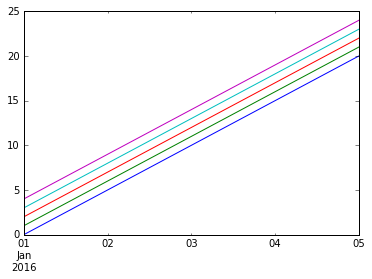

In [4]:
df.plot()
plt.legend().remove()


plot1
<bound method Axes.legend of <matplotlib.axes._subplots.AxesSubplot object at 0x7f6f2cceccc0>>


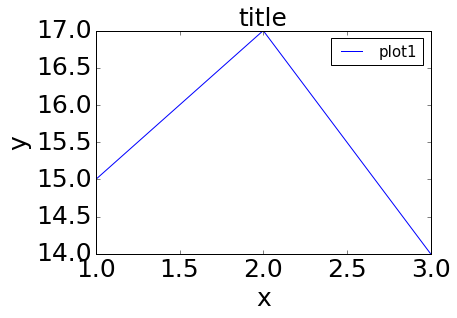

In [5]:
# http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
x1 = [1,2,3]
y1 = [15,17,14]

h1, = plt.plot(x1,y1, label='plot1')
print(h1.get_label()) #unpacked to Line2D(plot1)

plt.xlabel('x')
plt.ylabel('y')
plt.title('title')
plt.legend(fontsize = 15)

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(25)
print(ax.legend)





In [6]:
def myf(num):
  return num, (num+10, num+20), (num*2, num*4, num*10)

result, *rest = myf(1)

rest

[(11, 21), (2, 4, 10)]

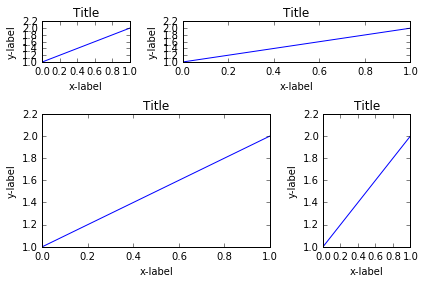

In [7]:
import matplotlib.pyplot as plt


def example_plot(ax):
    ax.plot([1, 2])
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    ax.set_title('Title')


fig = plt.figure()

ax1 = plt.subplot2grid((3, 3), (0, 0))
ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)

example_plot(ax1)
example_plot(ax2)
example_plot(ax3)
example_plot(ax4)

plt.tight_layout()

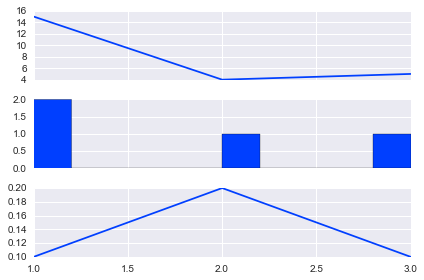

In [92]:
x1 = [1,2,3]
y1 = [15,4,5]
y2 = [0.1,0.2,0.1]

df = pd.DataFrame({'y1': y1, 'y2': y2}, index=x1)

fig = plt.figure()

ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))
ax3 = plt.subplot2grid((3, 1), (2, 0))


df['y1'].plot(ax=ax1)

plt.axes(ax2)
plt.hist([1,2,3,1])

df['y2'].plot(ax=ax3, sharex = ax1)

plt.tight_layout()

                   A         B         C         D         E
2016-01-01  0.538449  0.993661  0.320619  0.692138  0.562356
2016-01-02  0.127001  0.271106  0.355299  0.662303  0.227891
2016-01-03  0.091935  0.493164  0.849716  0.206476  0.981089
2016-01-04  0.795065  0.892812  0.530599  0.840625  0.427613
2016-01-05  0.531454  0.782090  0.226164  0.412022  0.351656


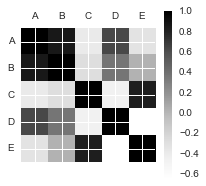

In [72]:
df = pd.DataFrame(np.random.rand(25).reshape(5,5), 
                      index=pd.date_range('1/1/2016', periods=5),
                      columns=list('ABCDE'))
print(df)
corr = df.corr()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.colorbar(h)
plt.set_cmap('Greys')

In [9]:
t = np.linspace(1,27,27).reshape(3,3,3)
pan = pd.Panel(t)

print(pan)
print(type(pan.iloc[0,:,:]))
print(type(pan.iloc[0,0,:]))
print(type(pan.iloc[0,0,0]))

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 3 (major_axis) x 3 (minor_axis)
Items axis: 0 to 2
Major_axis axis: 0 to 2
Minor_axis axis: 0 to 2
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'numpy.float64'>


product              Gloves  Pants  Shoes
date       minor                         
2013-01-01 price       10.0   50.0  100.0
           quantity     5.0   10.0   10.0
2013-01-02 price       12.5   55.5  102.5
           quantity     6.0   12.0   10.0
2013-01-03 price       10.0   50.0  100.0
           quantity     7.0   14.0   12.0

product              Gloves  Pants  Shoes
date       minor                         
2013-01-01 price      -10.0  -50.0 -100.0
           quantity    -5.0  -10.0  -10.0
2013-01-02 price      -12.5  -55.5 -102.5
           quantity    -6.0  -12.0  -10.0
2013-01-03 price      -10.0  -50.0 -100.0
           quantity    -7.0  -14.0  -12.0

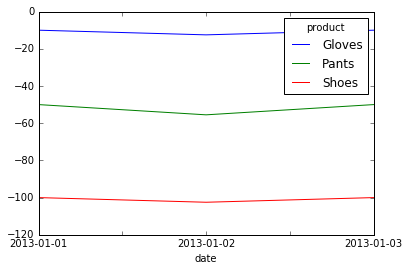

In [10]:
df = pd.read_csv('notes.csv', index_col=[0,1])

pan = df.to_panel()

pan = pan.swapaxes('minor','items')

display(pan.to_frame())

for column in pan.iloc[0].columns:
#     print(column)
    pan.loc[:,:,column] = - pan.loc[:,:,column]

display(pan.to_frame())

# Items axis: Gloves to Shoes
# Major_axis axis: 2013-01-01 to 2013-01-03
# Minor_axis axis: price to quantity


pan.loc[:,:,'price'].plot();

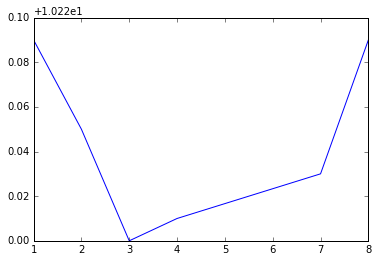

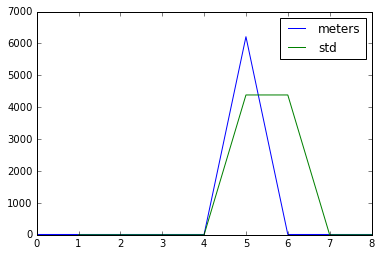

In [11]:
# example of removing outliers 
bridge_height = {'meters':[10.26, 10.31, 10.27, 10.22, 10.23, 6212.42, 10.28, 10.25, 10.31]}
df = pd.DataFrame(bridge_height)
df['std'] = df.rolling(window=2).std()
df_std=df.describe()['meters']['std']
df[df['std']<df_std]['meters'].plot()
df.plot()

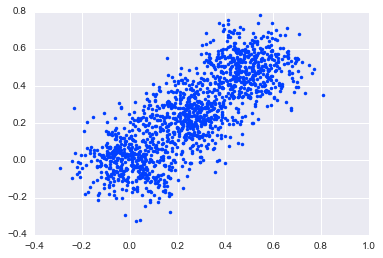

In [7]:
mu, sigma = 0, 0.1 # mean and standard deviation
x0 = np.random.normal(mu, sigma, 500)
y0 = np.random.normal(mu, sigma, 500)

mu, sigma = 0.25, 0.1 # mean and standard deviation
x1 = np.random.normal(mu, sigma, 500)
y1 = np.random.normal(mu, sigma, 500)

mu, sigma = 0.5, 0.1 # mean and standard deviation
x2 = np.random.normal(mu, sigma, 500)
y2 = np.random.normal(mu, sigma, 500)

x = np.concatenate((x0,x1,x2))
y = np.concatenate((y0,y1,y2))

fig, ax = plt.subplots()
ax.plot(x,y,'.')

In [5]:
# http://stackoverflow.com/questions/16626058/what-is-the-performance-impact-of-non-unique-indexes-in-pandas
x = np.random.randint(0, 200, 10**6)
df1 = pd.DataFrame({'x':x})
df2 = df1.set_index('x', drop=False)
df3 = df2.sort_index()
%timeit df1.ix[100]
%timeit df2.ix[100]
%timeit df3.ix[100]

The slowest run took 551.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 180 µs per loop
10 loops, best of 3: 32.4 ms per loop
The slowest run took 67.14 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 216 µs per loop


In [12]:
def whereami(df, ind, num_to_view=5):
    if not isinstance(df, pd.DataFrame):
        raise TypeError('must be pandas.core.frame.DataFrame')
    try:
        location = df.index.get_loc(str(ind))
    except KeyError:
         location = df.index.get_loc(ind)
            
    try: 
        new_location = slice(location.start-num_to_view, location.stop+num_to_view+1, location.step)
    except AttributeError:
        new_location = slice(location-num_to_view, location+num_to_view+1)
    return df[new_location]

tips = sns.load_dataset("tips")
whereami(tips,20,3)

,total_bill,tip,sex,smoker,day,time,size
17,16.29,3.71,Male,No,Sun,Dinner,3
18,16.97,3.50,Female,No,Sun,Dinner,3
19,20.65,3.35,Male,No,Sat,Dinner,3
20,17.92,4.08,Male,No,Sat,Dinner,2
21,20.29,2.75,Female,No,Sat,Dinner,2
22,15.77,2.23,Female,No,Sat,Dinner,2
23,39.42,7.58,Male,No,Sat,Dinner,4


peak memory: 129.04 MiB, increment: 53.76 MiB
CPU times: user 429 ms, sys: 269 ms, total: 697 ms
Wall time: 1.03 s


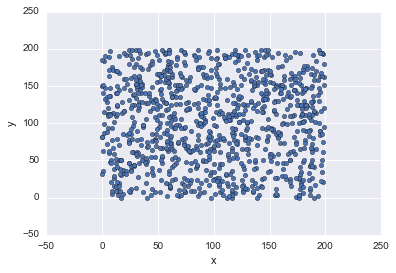

In [22]:
%%time 
%%memit pass
# down sampling in order to plot faster

x = np.random.randint(0, 200, 10**6)
y = np.random.randint(0, 200, 10**6)
df = pd.DataFrame({'x':x, 'y':y})
# df.shape # (1000000, 2)

df.sample(1000).plot(kind='scatter', x='x', y='y')

# without down sampling
# peak memory: 338.07 MiB, increment: 151.70 MiB
# CPU times: user 13.8 s, sys: 458 ms, total: 14.3 s
# Wall time: 14.3 s

In [50]:
# pitfalls, silent type convertion on datetime due to NaN
# http://stackoverflow.com/questions/36620256/why-is-pandas-converting-datetimes-to-float-in-aggregate-function
# https://github.com/pydata/pandas/issues/12941

df = pd.DataFrame(np.random.rand(250).reshape(50,5), 
                      index=pd.date_range('1/1/2016', periods=50, freq='H' ),
                      columns=list('ABCDE'))
df['timestamp'] = df.index

print(df.timestamp.resample('30min',label='right').last().head(3))
print('==========')
print(df.timestamp.resample('2H',label='right').last().head(3))


2016-01-01 00:30:00    1.451606e+18
2016-01-01 01:00:00             NaN
2016-01-01 01:30:00    1.451610e+18
Freq: 30T, Name: timestamp, dtype: float64
2016-01-01 02:00:00   2016-01-01 01:00:00
2016-01-01 04:00:00   2016-01-01 03:00:00
2016-01-01 06:00:00   2016-01-01 05:00:00
Freq: 2H, Name: timestamp, dtype: datetime64[ns]


In [51]:
# pitfalls, groupby column with NaN values erases the whole row
df = pd.DataFrame({'val0': [1.1,1.1,2.2,2.2,3.3,3.3,3.3], 'val1': [1,1,2,2,3,3,3], 'val2': [np.nan,'A','B','A','B','C',np.nan]})
display(df)

def myf(df):
    df['new_column'] = 666
    return df
df.groupby('val2').apply(myf)

,val0,val1,val2
0,1.1,1,NaN
1,1.1,1,A
2,2.2,2,B
3,2.2,2,A
4,3.3,3,B
5,3.3,3,C
6,3.3,3,NaN


,val0,val1,val2,new_column
0,NaN,NaN,NaN,NaN
1,1.1,1.0,A,666.0
2,2.2,2.0,B,666.0
3,2.2,2.0,A,666.0
4,3.3,3.0,B,666.0
5,3.3,3.0,C,666.0
6,NaN,NaN,NaN,NaN


In [57]:
# regex a list
import re

df = pd.DataFrame({'sample': ['A','B','B','C','C','C'], 'val': [10,40,30,10,11,12], 'text': [110,140,130,110,111,112], 'time_tick_num':[0,0,1,0,1,2]})

filter(lambda x:re.search(r'.*sam.*', x), df.columns.tolist())

['sample']

In [86]:
def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)
        print f.__name__, ' has already been run'
    wrapper.has_run = False
    return wrapper

class Myc:
    @run_once
    def myf(self):
        print 'running...'

myobj = Myc()
myobj.myf()
myobj.myf()


running...
myf  has already been run


In [3]:
coef_array = np.empty((3,3))
coef_array[:] = np.NaN
coef_array[1,:] = [1,2,3]
coef_array

array([[ nan,  nan,  nan],
       [  1.,   2.,   3.],
       [ nan,  nan,  nan]])

In [6]:
# using self.var_name as default value for 
class Myc:
    def __init__(self):
        self.num = 2
    def myf(self, run_times=None):
        if run_times is None:
            run_times = self.num
        for i in range(run_times):
            print 'running...'

myobj = Myc()
myobj.myf()
print '======'
myobj.myf(1)


running...
running...
running...


In [11]:
# parsing generic functions and arguments
def myf(lm, **args):
#     args['cv'] = 'hep'
    print args
    model = lm(**args)
    X_train = [[1,2,2],[3,4,4]]
    y_train = [100,200]
    
    result = model.fit(X_train, y_train)  
    return result

my_model = Ridge
res = myf(my_model, alpha=0.1)
print res.coef_

my_model = Lasso
res = myf(my_model)
print res.coef_

NameError: name 'Ridge' is not defined

In [9]:
arr = np.empty((0,2))

arr = np.vstack([arr, [1,2]])
arr = np.vstack([arr, [3,4]])

print type(arr)
arr

<type 'numpy.ndarray'>


array([[ 1.,  2.],
       [ 3.,  4.]])

In [10]:
arr=[0,1,2,3,4,5]
for i in range(0,3):
    print arr[:-i or None]

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4]
[0, 1, 2, 3]
